# Objective:  Creating a predictive model which can predict the insurance premium based on certain features like (age, gender, bmi, smoker etc)

# Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
# Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No null values present

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [5]:
df.drop_duplicates(inplace=True)

# Visualizing Data

### Visualizing categorical features relation with "expenses"

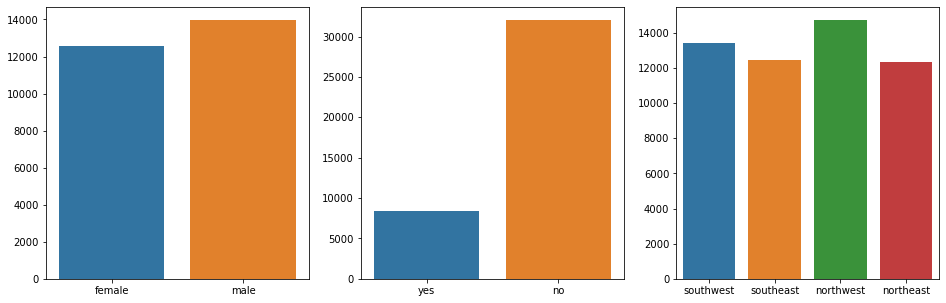

In [6]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sex_df = df.groupby('sex')
sns.barplot(x=df['sex'].unique(), y=(sex_df['expenses'].sum() / sex_df['sex'].count()))
plt.subplot(1,3,2)
smoker_df = df.groupby('smoker')
sns.barplot(x=df['smoker'].unique(), y=(smoker_df['expenses'].sum() / smoker_df['smoker'].count()))
plt.subplot(1,3,3)
region_df = df.groupby('region')
sns.barplot(x=df['region'].unique(), y=(region_df['expenses'].sum() / region_df['region'].count()))

plt.show()

__Observation:__ 
1. Male average expeses are greater than female average expenses
2. Smokers average expenses are greater than non smokers average expenses
3. Northwest average expenses are higher than other regions average expenses

All categorical features are correlated with expenses

### Visualizing numerical features relation with "expenses"

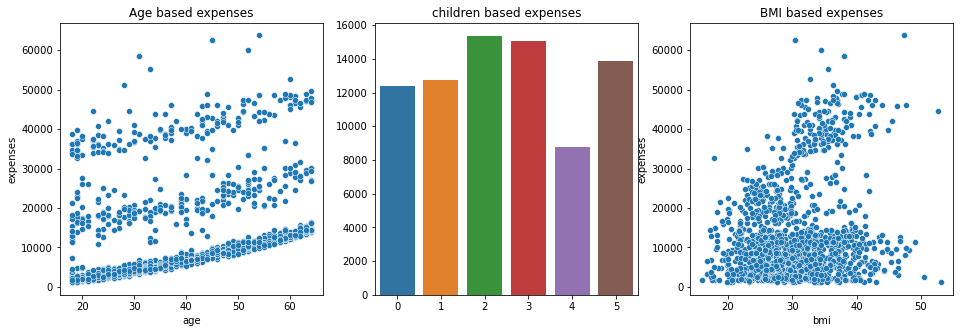

In [7]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.scatterplot(x=df['age'], y=df['expenses'])
plt.title('Age based expenses')

plt.subplot(1,3,2)
children_df = df.groupby('children')
sns.barplot(x=df['children'].unique(), y=(children_df['expenses'].sum() / children_df['children'].count()))
plt.title('children based expenses')

plt.subplot(1,3,3)
sns.scatterplot(x=df['bmi'], y=df['expenses'])
plt.title('BMI based expenses')
plt.show()

__Observation:__
1. Age and BMI is showing linear positive relation with expenses
2. Children is showing vary low positive relation with expenses

### Checking for outliers in BMI and Age feature

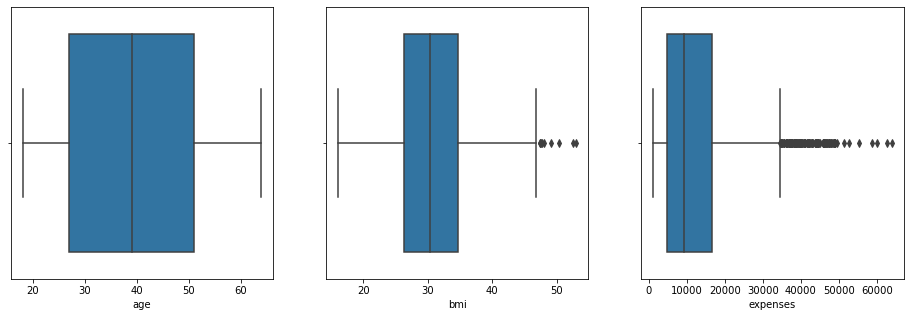

In [8]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(df['age'])

plt.subplot(1,3,2)
sns.boxplot(df['bmi'])

plt.subplot(1,3,3)
sns.boxplot(df['expenses'])

plt.show()

children is a categorical column which has values from 1 to 5 bmi and age features has skewness

### Performing Log Transformation in bmi & expenses to remove the outliers

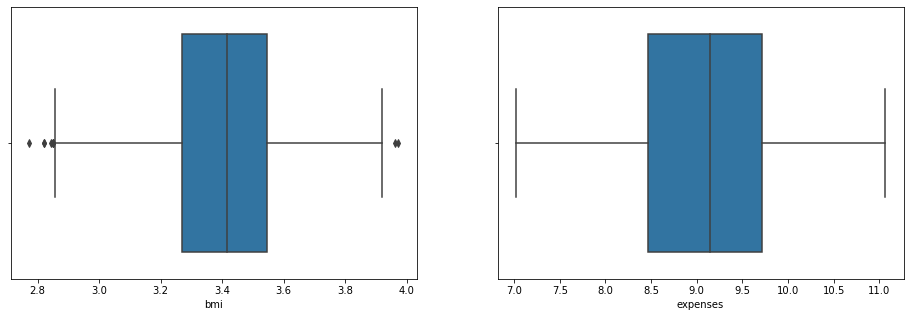

In [9]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.boxplot(np.log(df['bmi']))

plt.subplot(1,2,2)
sns.boxplot(np.log(df['expenses']))

plt.show()

__Log transformation working perfectly for expenses but with bmi it still has some outliers__

### Performing boxcox, square root, cube root transformation in bmi

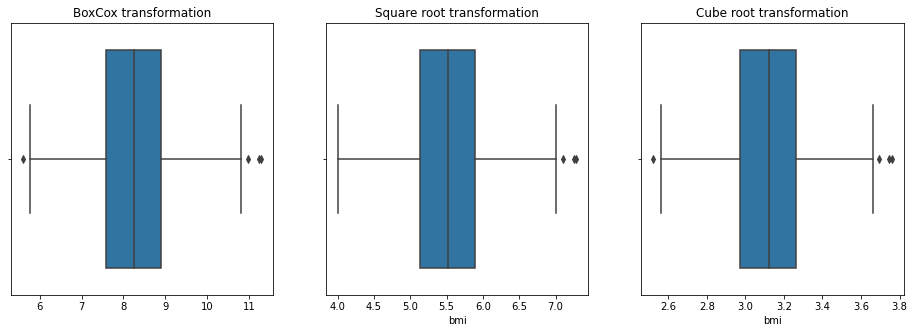

In [10]:
from scipy import stats

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(stats.boxcox(df['bmi'])[0])
plt.title('BoxCox transformation')

plt.subplot(1,3,2)
sns.boxplot(np.sqrt(df['bmi']))
plt.title('Square root transformation')

plt.subplot(1,3,3)
sns.boxplot(np.cbrt(df['bmi']))
plt.title('Cube root transformation')

plt.show()

__With square root transformation almost all the outliers are sattled__

## Applying transformation changes

In [11]:
df['expenses'] = np.log(df['expenses'])
df['bmi'] = np.sqrt(df['bmi'])

## To remove remaining outliers from bmi performing winsorizing 

In [12]:
from scipy.stats.mstats import winsorize

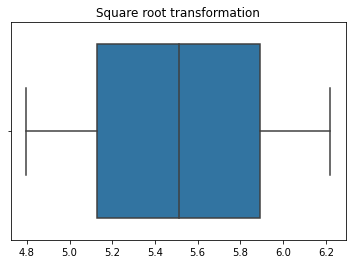

In [13]:
sns.boxplot(winsorize(df['bmi'], (0.1, 0.1)))
plt.title('Square root transformation')

plt.show()

In [14]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols=['sex', 'smoker', 'region'], return_df=True )
one_hot_df = encoder.fit_transform(df)

In [15]:
one_hot_df.head()

,age,sex_1,sex_2,bmi,children,smoker_1,smoker_2,region_1,region_2,region_3,region_4,expenses
0,19,1,0,5.282045,0,1,0,1,0,0,0,9.734176
1,18,0,1,5.813777,1,0,1,0,1,0,0,7.453301
2,28,0,1,5.744563,3,0,1,0,1,0,0,8.400538
3,33,0,1,4.764452,0,0,1,0,0,1,0,9.998092
4,32,0,1,5.375872,0,0,1,0,0,1,0,8.260198


In [16]:
# droping 1st value feature from one-hot encoded features
one_hot_df.drop(['sex_1', 'smoker_1', 'region_1'], axis=1, inplace=True)

In [17]:
X = one_hot_df.drop('expenses', axis=1)
Y = one_hot_df['expenses']

## EDA with Pandas Profiling

In [18]:
from pandas_profiling import ProfileReport

ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Spliting the dataset

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25, random_state=101)
trainX.shape, trainY.shape, testX.shape, testY.shape

((1002, 8), (1002,), (335, 8), (335,))

### Scaling the pre-processed values

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX, trainY)
testX = scaler.transform(testX)

### 1. Applying Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(trainX, trainY)

LinearRegression()

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def get_model_evaluation_report(model):
    train_pred = model.predict(trainX)
    test_pred = model.predict(testX)

    metrics = {
                'train': {
                    'r2_score': r2_score(trainY, train_pred),
                    'mae': mean_absolute_error(trainY, train_pred),
                    'mse': mean_squared_error(trainY, train_pred),
                    'rmse': np.sqrt(mean_squared_error(trainY, train_pred))
                },
                'test': {
                    'r2_score': r2_score(testY, test_pred),
                    'mae': mean_absolute_error(testY, test_pred),
                    'mse': mean_squared_error(testY, test_pred),
                    'rmse': np.sqrt(mean_squared_error(testY, test_pred))
                }
            }

    return metrics

### Linear Regression model evaluation

In [25]:
get_model_evaluation_report(lr_model)

{'train': {'r2_score': 0.7643206320228861,
  'mae': 0.28081686937674716,
  'mse': 0.1998443971857749,
  'rmse': 0.44703959241411145},
 'test': {'r2_score': 0.7767509646559473,
  'mae': 0.2737232656350579,
  'mse': 0.18485345295702016,
  'rmse': 0.42994587212464336}}

### 2. Lasso Regression Model

In [26]:
from sklearn.linear_model import LassoCV

lasso_alpha = np.linspace(0, 1, 20)
cv = 5

lasso_model = LassoCV(alphas=lasso_alpha, cv=cv, n_jobs=-1, random_state=101)
lasso_model.fit(trainX, trainY)

LassoCV(alphas=array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
        cv=5, n_jobs=-1, random_state=101)

In [27]:
lasso_model.alpha_

0.0

In [28]:
get_model_evaluation_report(lasso_model)

{'train': {'r2_score': 0.7643206320228861,
  'mae': 0.2808168693767474,
  'mse': 0.1998443971857749,
  'rmse': 0.44703959241411145},
 'test': {'r2_score': 0.7767509646559474,
  'mae': 0.27372326563505806,
  'mse': 0.18485345295702013,
  'rmse': 0.4299458721246433}}

### 3. Ridge Regression Model

In [29]:
from sklearn.linear_model import RidgeCV

lasso_alpha = np.linspace(0, 5, 20)
cv = 5

ridge_model = RidgeCV(alphas=lasso_alpha, cv=cv)
ridge_model.fit(trainX, trainY)

RidgeCV(alphas=array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ]),
        cv=5)

In [30]:
ridge_model.alpha_

0.0

In [31]:
get_model_evaluation_report(ridge_model)

{'train': {'r2_score': 0.7643206320228861,
  'mae': 0.2808168693767473,
  'mse': 0.1998443971857749,
  'rmse': 0.44703959241411145},
 'test': {'r2_score': 0.776750964655947,
  'mae': 0.2737232656350583,
  'mse': 0.18485345295702038,
  'rmse': 0.4299458721246436}}

### Creating get_best_hyper_parameters function for hyper parameter tuning

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def get_best_hyper_parameters(estimator, parameters: dict,
                              search_method='GridSearchCV', cv=5,
                              scoring='r2', n_jobs=-1, verbose=1):
    if search_method == 'GridSearchCV':
        search_cv = GridSearchCV(
            estimator=estimator,
            param_grid=parameters,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=verbose,
            error_score='raise'
        )
    elif search_method == 'RandomizedSearchCV':
        search_cv = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=parameters,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=verbose)
    
    search_cv.fit(trainX, trainY)
    print(f'Scoring {scoring} = {search_cv.best_score_}')
    return search_cv.best_params_

### Random Forest hyper parameters

In [33]:
# Number of trees in random forest
n_estimators = range(1, 20, 2)
# Maximum number of levels in tree
max_depth = range(5, 15, 2)
# Minimum number of samples required to split a node
min_samples_split = range(10, 30, 2)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(5, 15, 2)

In [34]:
hyper_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                }

### 4. Applying Random Forest Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

best_hyper_params = get_best_hyper_parameters(
    RandomForestRegressor(), hyper_params
)

best_hyper_params

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
Scoring r2 = 0.8296299729084675


{'max_depth': 5,
 'min_samples_leaf': 7,
 'min_samples_split': 12,
 'n_estimators': 17}

In [36]:
model = RandomForestRegressor(**best_hyper_params)
model.fit(trainX, trainY)

RandomForestRegressor(max_depth=5, min_samples_leaf=7, min_samples_split=12,
                      n_estimators=17)

### Random Forest model evaluation

In [37]:
get_model_evaluation_report(model)

{'train': {'r2_score': 0.8557524239872856,
  'mae': 0.180582949736783,
  'mse': 0.12231477927490657,
  'rmse': 0.3497352988688825},
 'test': {'r2_score': 0.8341639366383266,
  'mae': 0.21159904283557593,
  'mse': 0.13731467591768554,
  'rmse': 0.3705599491549047}}

### 5. Applying SVM Regression

In [55]:
from sklearn.svm import SVR

svr_model = SVR()

In [56]:
hyper_params = {
    'degree': range(1, 6),
    'epsilon': np.linspace(0.01, 1, 10)
}

In [57]:
best_hyper_params = get_best_hyper_parameters(
    svr_model, hyper_params
)

best_hyper_params

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Scoring r2 = 0.8240393752546605


{'degree': 1, 'epsilon': 0.12, 'kernel': 'rbf'}

### SVM model evaluation

In [58]:
svr_model = SVR(**best_hyper_params)
svr_model.fit(trainX, trainY)

get_model_evaluation_report(svr_model)

{'train': {'r2_score': 0.8408745493486558,
  'mae': 0.16630169132692035,
  'mse': 0.13493047794247598,
  'rmse': 0.3673288416970222},
 'test': {'r2_score': 0.8402913823945604,
  'mae': 0.18947512985482975,
  'mse': 0.13224106158335672,
  'rmse': 0.36364964125289156}}

### 6. Applying XGBoost Regression

In [42]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

In [43]:
hyper_params = {
                    'n_estimators': range(10, 50, 10),
                    'max_depth': range(10, 20, 2),
                    'gamma': np.linspace(0, 2, 5)
                }

In [44]:
best_hyper_params = get_best_hyper_parameters(
    xgb_model, hyper_params
)

best_hyper_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Scoring r2 = 0.8171742779201004


{'gamma': 2.0, 'max_depth': 10, 'n_estimators': 40}

In [45]:
xgb_model = XGBRegressor()

eval_set = [(testX, testY)]

xgb_model.fit(trainX, trainY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### XGBoost Model Evaluation

In [46]:
get_model_evaluation_report(xgb_model)

{'train': {'r2_score': 0.9952913165191336,
  'mae': 0.03628905648832657,
  'mse': 0.003992729698187859,
  'rmse': 0.0631880502800004},
 'test': {'r2_score': 0.7757923669864043,
  'mae': 0.23589459742068597,
  'mse': 0.18564718578967718,
  'rmse': 0.43086794472283174}}